# DMQC Report: WMO 4900881

## Current status and metadata: 

- APEX float deployed off Scotian Shelf, travelled to Florida and back
- Collected 162 cycles from October 2006 to March 2011
- In 'A' mode, gain of 1.072551 applied
- Mean gain of 1.0554

In [3]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4900881 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

\Users\GordonC\Documents\data\Argo\dac\meds\4900881\4900881_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900881\4900881_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900881\4900881_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900881\4900881_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900881\4900881_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data -

## DOXY Audit Status

- If the float has any profiles present in the DOXY audit, which are they are why?
- Likely will usually be left empty/deleted

In [4]:
audit_file = list(Path('../../../audit/').glob('DOXY_WOA*'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df)

    DAC             PI SPROF DATE_UPDATE DATA MODE      WMO  cycle  \
2  meds  Blair Greenan    06/28/22 16:11         A  4900881     29   
3  meds  Blair Greenan    06/28/22 16:11         A  4900881    134   

     profile date    lon    lat  WOA T  ...  PRES   TEMP   PSAL  flt O2 %sat  \
2  07/28/07 22:06 -73.23  37.31  22.46  ...  19.6  17.13  34.28       114.21   
3  06/12/10 21:56 -53.03  41.63  15.09  ...  11.2  19.23  35.87        89.65   

   flt O2adj %sat  WOA G_raw  WOA G_adj  Z_WOAraw  Z_WOAadj          date  
2          121.95       0.92       0.86      3.40       5.7  13722.920833  
3           93.67       1.19       1.14      2.47       5.4  14772.913889  

[2 rows x 22 columns]


## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

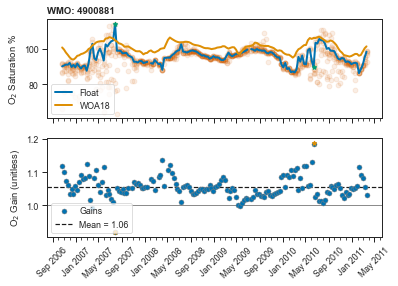

In [5]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: These don't look egregious, especially the second audit one where there is lots of oscillation anyway. 

(100.0, 0.0)

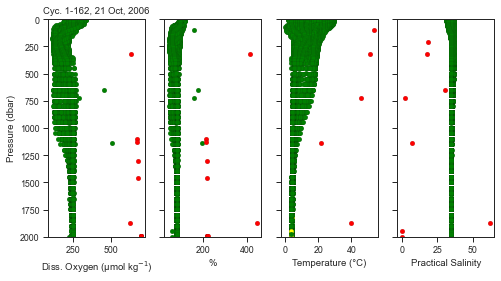

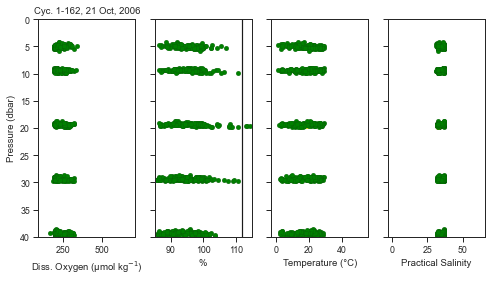

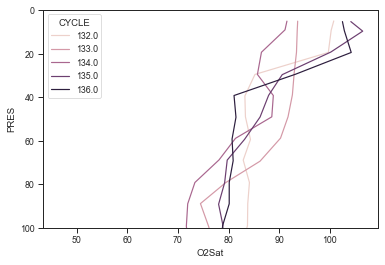

In [6]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((40,0))
g.axes[1].set_xlim(left=85,right=115)
g.axes[1].axvline(112, color='k')
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)


import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(data=flt.df.loc[flt.df.CYCLE.isin([28, 29, 30, 133, 134, 135])], x='O2Sat', y='PRES', hue='CYCLE', sort=False, ax=ax)
ax.set_ylim((100,0))

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: Going to leave cycle 134 as in. Cycle 29 also looks fine to me, but just is high in the float average because it is missing some points near the surface. I will exclude that one from the gain calculation but leave it as good data.  

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.


Calculating gains using WOA surface data and float O2 percent saturation...
1.0562663366298648


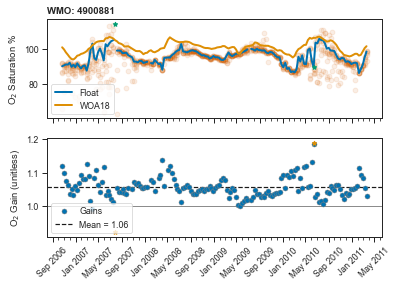

In [7]:
bad_oxygen = [flt.df.CYCLE == 29] # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

flt.update_field('DOXY_QC', 3, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=bad_oxygen)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [8]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# apply gain and calculate error
flt.update_field('DOXY_ADJUSTED', flt.gain*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

In [11]:
# export the files
flt.export_files(data_mode='D')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles/BD4900881_009.nc...done
Working on

In [14]:
import sys
import copy
from netCDF4 import Dataset

df = pd.read_csv('../../../checker/summary/4900881/files.txt')

prof_list = ['BD4900881_057.nc',
'BD4900881_059.nc',
'BD4900881_072.nc',
'BD4900881_109.nc',
'BD4900881_111.nc',
'BD4900881_128.nc',
'BD4900881_141.nc',
'BD4900881_142.nc',
'BD4900881_143.nc',
'BD4900881_144.nc',
'BD4900881_145.nc']

for fn in df.files:
    full_fn = Path('/Users/GordonC/Documents/data/Argo/dac/meds/D/4900881/profiles') / fn
    sys.stdout.write(f'Working on {full_fn}...')
    nc = Dataset(full_fn, 'r+')
    for varname in ['DOXY']:
        flags = copy.deepcopy(nc[varname+'_QC'][:])
        flags[nc[varname][:].mask] = b'9'
        nc[varname+'_QC'][:] = flags
        if varname == 'DOXY':
            flags = copy.deepcopy(nc[varname+'_ADJUSTED_QC'][:])
            flags[nc[varname][:].mask] = b'9'
            nc[varname+'_ADJUSTED_QC'][:] = flags
    if fn in prof_list:
        profile = copy.deepcopy(nc['PROFILE_DOXY_QC'][:])
        profile[0] = b'A'
        nc['PROFILE_DOXY_QC'][:] = profile

    nc.close()
    sys.stdout.write('done\n')

Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_057.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_059.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_072.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_109.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_111.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_128.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_141.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_142.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_143.nc...done
Working on \Users\GordonC\Documents\data\Argo\dac\meds\D\4900881\profiles\BD4900881_144.nc...done
Working on \Users\Go